In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v5 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.2 kB]
Ge

In [10]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math
import os
import utils
from utils import plotLearning

#from dueling_dqn_torch import Agent

ImportError: ignored

In [3]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 0.         -0.          0.         -0.          0.02       -0.
  0.11059734 -0.          0.         -0.00191829]


In [6]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,n_actions):
    self.mem_size = max_size
    self.mem_cntr= 0 
    self.state_memory =np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size,*input_shape),dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size,dtype = np.int64)
    self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size , dtype = np.uint8)

  def store_transition(self,state,action,reward,new_state,done):
    index=self.mem_cntr % self.mem_size

    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.new_state_memory[index] = new_state
    self.terminal_memory[index]=done

    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min (self.mem_cntr,self.mem_size)
    batch = np.random.choice(max_mem,batch_size,replace=False)
    
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    new_states = self.new_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, actions, rewards ,new_states ,dones

In [18]:
class DuelingLinearDeepQNetwork(nn.Module):
  def __init__(self, ALPHA, n_actions , name , input_dims , chkpt_dir ='tmp/dueling_dqn'):
    super(DuelingLinearDeepQNetwork,self).__init__()

    self.fc1 = nn.Linear(*input_dims,128)
    self.fc2 =nn.Linear(128,128)
    self.V =nn.Linear(128,1)
    self.A=nn.Linear(128,n_actions)
    
    self.optimizer = optim.Adam(self.parameters() , lr =ALPHA)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir,name+'dueling')

  def forward(self,state):
    l1 = F.relu(self.fc1(state))
    l2 = F.relu(self.fc2(l1))
    V= self.V(l2)
    A= self.A(l2)

    return V,A

  def save_checkpoint(self):
    print('save checkpoint ...')
    T.save(self.state_dict(),self.checkpoint_file)


  def load_checkpoint(self):
    print('load checkpoint ...')
    self.load_state_dict(T.load(self.checkpoint_file))

In [26]:
class Agent(object):
  def __init__(self,gamma,epsilon,alpha,n_actions,input_dims,mem_size,batch_size,eps_min=0.01,eps_dec = 5e-7,replace =1000,chkpt_dir = 'tmp/dueling_dqn'):

    self.gamma = gamma 
    self.epsilon=epsilon
    self.eps_min=eps_min
    self.eps_dec=eps_dec
    self.action_space =[i for i in range(n_actions)]
    self.learn_step_counter = 0
    self.replace_target_cnt = replace
    self.batch_size=batch_size
    self.memory = ReplayBuffer(mem_size,input_dims,n_actions)
    self.q_eval = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_eval' , chkpt_dir =chkpt_dir )

    self.q_next = DuelingLinearDeepQNetwork(alpha,n_actions,input_dims=input_dims,name='q_next' , chkpt_dir =chkpt_dir )


  def store_transition(self,state,action,reward, state_ , done):
    self.memory.store_transition(state,action,reward, state_ , done)

  def choose_action(self,observation):
    if np.random.random() > self.epsilon :
        observation = observation[np.newaxis, :]
        state = T.tensor(observation).to(self.q_eval.device)
        _,advantage =self.q_eval.forward(state)
        action = T.argmax(advantage).item()
    else:
        action = np.random.choice(self.action_space)
    return action

  def replace_target_network(self):
      if self.replace_target_cnt is not None and self.learn_step_counter % self.replace_target_cnt == 0:
        self.q_next.load_state_dict(self.q_eval.state_dict())
      
  def decremen_epsilon(self):
      self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  
  def learn(self):
      if self.memory.mem_cntr  <self.batch_size:
        return
      
      self.q_eval.optimizer.zero_grad()
      self.replace_target_network()

      state,action,reward,new_state,done =self.memory.sample_buffer(self.batch_size)

      state=T.tensor(state).to(self.q_eval.device)
      new_state = T.tensor(new_state).to(self.q_eval.device)
      action = T.tensor(action).to(self.q_eval.device)
      reward = T.tensor(reward).to(self.q_eval.device)
      dones= T.tensor(done).to(self.q_eval.device)

      V_s,A_s = self.q_eval.forward(state)
      V_s_ ,A_s_ = self.q_next.forward(new_state)

      q_pred = T.add(V_s,(A_s-A_s.mean(dim=1 , keepdim=True))).gather(1,action.unsqueeze(-1)).squeeze(-1)

      q_next = T.add(V_s_,(A_s_-A_s_.mean(dim=1 , keepdim=True)))

      q_target = reward + self.gamma*T.max(q_next , dim=1)[0].detach()
      q_target[dones] = 0.0

      loss = self.q_eval.loss(q_target,q_pred).to(self.q_eval.device)
      loss.backward()
      self.q_eval.optimizer.step()
      self.learn_step_counter +=1

      self.decremen_epsilon()

  def save_models(self):
      self.q_eval.save_checkpoint()
      self.q_next.save_checkpoint()

  def load_models(self):
      self.q_eval.load_checkpoint()
      self.q_next.load_checkpoint()


In [31]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1391.)


shout entos periohis Ball Position 0.65771127 0.10168791 0.11304705 episode 0 step= 93
ball is out -10 episode 0 Ball Position 0.99251795 0.075903535 0.20106752 step= 105
---Avg reward last: -16.035160419083798 Avg score last 0.0 Avg steps 106.0 episode= 0 ---
shout entos periohis Ball Position 0.66077405 0.072559245 0.11135287 episode 1 step= 105
goal episode 1 step= 115
shout entos periohis Ball Position 0.6614645 0.031454988 0.13165462 episode 2 step= 109
goal episode 2 step= 120
shout entos periohis Ball Position 0.7004419 0.06388019 0.114707194 episode 3 step= 109
goal episode 3 step= 118
shout entos periohis Ball Position 0.67344046 -0.007430214 0.119898856 episode 4 step= 102
goal episode 4 step= 112
shout entos periohis Ball Position 0.83058846 -0.058006585 0.118522346 episode 5 step= 130
ball is out -10 episode 5 Ball Position 1.000602 -0.06381904 0.8437221 step= 137
shout entos periohis Ball Position 0.6637844 0.02963821 0.1264524 episode 6 step= 112
goal episode 6 step= 124


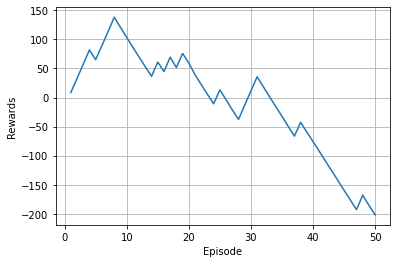

ball is out -10 episode 51 Ball Position 1.0107143 -0.15971133 0.12909979 step= 160
ball is out -10 episode 52 Ball Position 1.0107915 -0.16625115 0.12678172 step= 159
ball is out -10 episode 53 Ball Position 1.0141991 -0.12593074 0.112579584 step= 146
shout entos periohis Ball Position 0.7131999 -0.088431835 0.11151894 episode 54 step= 114
goal episode 54 step= 126
shout entos periohis Ball Position 0.80647814 -0.11168832 0.11671214 episode 55 step= 125
ball is out -10 episode 55 Ball Position 1.0083423 -0.079039246 0.7714799 step= 133
ball is out -10 episode 56 Ball Position 1.0090325 -0.23799394 0.11285788 step= 152
shout entos periohis Ball Position 0.6691652 -0.084368184 0.111420386 episode 57 step= 105
goal episode 57 step= 117
ball is out -10 episode 58 Ball Position 1.0129637 -0.22410853 0.12622175 step= 159
ball is out -10 episode 59 Ball Position 1.0128243 -0.23391564 0.11741936 step= 160
shout entos periohis Ball Position 0.66166425 -0.020804578 0.11133317 episode 60 step= 9

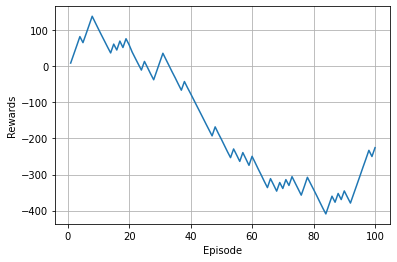

ball is out -10 episode 101 Ball Position 1.0129288 -0.061381306 0.11065198 step= 161
shout entos periohis Ball Position 0.9610679 -0.090687625 0.11622156 episode 102 step= 155
goal episode 102 step= 160
shout entos periohis Ball Position 0.83731866 -0.03084726 0.11247139 episode 103 step= 125
ball is out -10 episode 103 Ball Position 1.0182211 -0.048849475 0.64810467 step= 132
shout entos periohis Ball Position 0.8952048 0.015531158 0.1159906 episode 104 step= 143
goal episode 104 step= 148
ball is out -10 episode 105 Ball Position 1.0123128 -0.09095154 0.11484002 step= 162
shout entos periohis Ball Position 0.6667591 0.09118681 0.11152587 episode 106 step= 110
ball is out -10 episode 106 Ball Position 0.99636704 0.07500865 0.5946186 step= 121
shout entos periohis Ball Position 0.6585458 0.12709643 0.1326544 episode 107 step= 103
ball is out -10 episode 107 Ball Position 1.0166398 0.074085206 0.12094667 step= 115
goal episode 108 step= 161
shout entos periohis Ball Position 0.6606333 

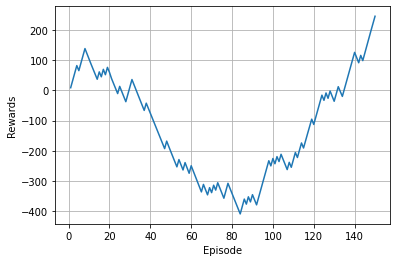

shout entos periohis Ball Position 0.8899606 -0.16292325 0.11993394 episode 151 step= 132
goal episode 151 step= 140
shout entos periohis Ball Position 0.9991003 0.10672256 0.112037726 episode 152 step= 161
ball is out -10 episode 152 Ball Position 1.0092995 0.100214906 0.1114325 step= 163
shout entos periohis Ball Position 0.9654015 0.0113040665 0.12440837 episode 153 step= 162
goal episode 153 step= 167
shout entos periohis Ball Position 0.97953016 0.06095899 0.12158508 episode 154 step= 158
ball is out -10 episode 154 Ball Position 1.0059983 0.07791761 0.10768707 step= 162
shout entos periohis Ball Position 0.663046 -0.05088206 0.114334635 episode 155 step= 101
goal episode 155 step= 114
shout entos periohis Ball Position 0.66142344 -0.012848963 0.11193125 episode 156 step= 107
goal episode 156 step= 118
shout entos periohis Ball Position 0.7556217 -0.003233536 0.10730419 episode 157 step= 122
goal episode 157 step= 131
shout entos periohis Ball Position 0.97386116 0.051952437 0.113

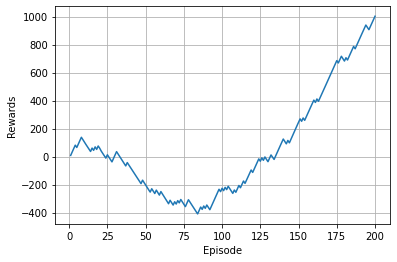

shout entos periohis Ball Position 0.94557697 -0.03988765 0.12595496 episode 201 step= 153
goal episode 201 step= 157
shout entos periohis Ball Position 0.7773265 -0.015552984 0.10925779 episode 202 step= 118
goal episode 202 step= 127
shout entos periohis Ball Position 0.66138023 0.022424221 0.10851512 episode 203 step= 101
goal episode 203 step= 111
shout entos periohis Ball Position 0.6639127 0.042326383 0.12781766 episode 204 step= 103
goal episode 204 step= 113
shout entos periohis Ball Position 0.98356235 -0.067022026 0.115806684 episode 205 step= 162
ball is out -10 episode 205 Ball Position 1.0131723 -0.062932834 0.1317133 step= 165
shout entos periohis Ball Position 0.94476813 -0.020328637 0.109994866 episode 206 step= 147
goal episode 206 step= 151
shout entos periohis Ball Position 0.71175325 -0.04628836 0.12137396 episode 207 step= 116
ball is out -10 episode 207 Ball Position 1.0000244 -0.060452558 0.38381213 step= 126
shout entos periohis Ball Position 0.99158716 -0.01570

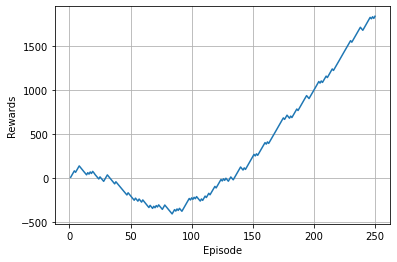

shout entos periohis Ball Position 0.80488586 0.019165153 0.10656155 episode 251 step= 129
goal episode 251 step= 135
shout entos periohis Ball Position 0.82507676 -0.03573353 0.116497904 episode 252 step= 127
goal episode 252 step= 133
shout entos periohis Ball Position 0.66641736 -0.02323118 0.10508844 episode 253 step= 104
ball is out -10 episode 253 Ball Position 0.9800322 -0.0540897 0.87322396 step= 114
shout entos periohis Ball Position 0.66157365 0.063434325 0.12913299 episode 254 step= 102
goal episode 254 step= 113
shout entos periohis Ball Position 0.6661785 0.0876221 0.12784837 episode 255 step= 100
goal episode 255 step= 112
goal episode 256 step= 148
shout entos periohis Ball Position 0.6637804 0.018511208 0.11075007 episode 257 step= 111
ball is out -10 episode 257 Ball Position 1.0074015 -0.04524335 0.1498875 step= 122
shout entos periohis Ball Position 0.66133034 -0.026700597 0.111621216 episode 258 step= 100
goal episode 258 step= 111
goal episode 259 step= 158
goal ep

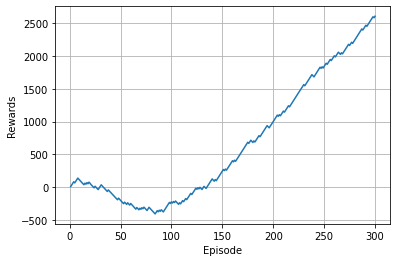

shout entos periohis Ball Position 0.6603192 0.023356995 0.10956404 episode 301 step= 102
goal episode 301 step= 114
shout entos periohis Ball Position 0.778094 -0.03816975 0.11089413 episode 302 step= 131
goal episode 302 step= 138
shout entos periohis Ball Position 0.69690293 0.008764411 0.12305779 episode 303 step= 104
goal episode 303 step= 115
shout entos periohis Ball Position 0.8159206 0.019574452 0.10778611 episode 304 step= 124
goal episode 304 step= 130
shout entos periohis Ball Position 0.6654877 0.0044383695 0.12995365 episode 305 step= 105
goal episode 305 step= 114
shout entos periohis Ball Position 0.66273546 0.020821486 0.11856416 episode 306 step= 99
goal episode 306 step= 110
shout entos periohis Ball Position 0.80075675 -0.041733656 0.11776745 episode 307 step= 132
goal episode 307 step= 138
shout entos periohis Ball Position 0.6608857 -0.05179878 0.13267955 episode 308 step= 100
goal episode 308 step= 109
ball is out -10 episode 309 Ball Position 1.0108925 0.0730095

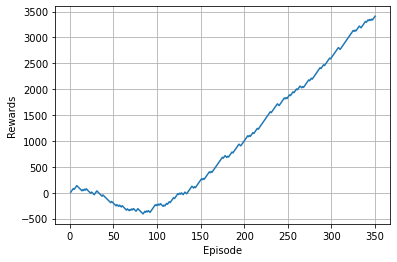

shout entos periohis Ball Position 0.8555371 -0.08181203 0.11652023 episode 351 step= 137
goal episode 351 step= 144
shout entos periohis Ball Position 0.8077642 -0.047162507 0.111632444 episode 352 step= 131
goal episode 352 step= 138
shout entos periohis Ball Position 0.86658365 -0.09568488 0.113218196 episode 353 step= 148
goal episode 353 step= 155
shout entos periohis Ball Position 0.7633593 -0.05771277 0.11064611 episode 354 step= 126
goal episode 354 step= 135
shout entos periohis Ball Position 0.87964255 -0.024483204 0.113285564 episode 355 step= 138
goal episode 355 step= 142
shout entos periohis Ball Position 0.659864 0.078899145 0.11027065 episode 356 step= 99
goal episode 356 step= 112
shout entos periohis Ball Position 0.66149515 0.037078455 0.12988229 episode 357 step= 105
goal episode 357 step= 114
shout entos periohis Ball Position 0.81474984 -0.04741795 0.11074045 episode 358 step= 128
ball is out -10 episode 358 Ball Position 0.98856777 -0.05326153 0.56724566 step= 13

In [45]:

env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')
num_games =400

load_checkpoint =False
Action_list=[4,5,6,12]
agent=Agent(gamma=0.99 , epsilon = 1.0 , alpha = 0.00115 , input_dims = [10] , n_actions = len(Action_list) ,mem_size =1000000,eps_min=0.01,batch_size =64 
                  ,eps_dec=1e-3 , replace =100)

all_prints = All_prints()
if load_checkpoint:
  agent.load_models()

filename='ddqn_gfootball.png'
scores=[]
eps_history=[]
steps=0
terminal =0
episode =0
shout =0

eps_rew=0
rew_list = []
step_list =[]
score_list=[]
total_rewards = []

for i in range(num_games):
  done = False 
  score = 0
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")



   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    
    if(done ==1 and reward != 1): #if ball is out ,loses -10
      
      reward = reward -10
      print("ball is out -10","episode",i,"Ball Position",observation[4],observation[5],observation[6],"step=",steps)

    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward = reward + 30

    #if((observation[0]<0.5)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      #reward= reward -200
      #done=1
      #print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.6) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis Ball Position",observation[4],observation[5],observation[6],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.1) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
   
    score= +reward
    eps_rew+=reward
    agent.store_transition(observation,action,reward,new_observation , int(done))

    agent.learn()
    observation = new_observation
    steps=steps+1

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)



  scores.append(score)
  avg_score = np.mean(scores[-100:])

  #print('episode',i,'score %.1f average score %.1f epsilon %2.f' %(score,avg_score,agent.epsilon))

  

  episode = episode +1 

  rew_list.append(eps_rew)
  # PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)

  


  eps_history.append(agent.epsilon)

x=[i + 1 for i in range(num_games)]
#plotLearning(x,scores,eps_history,filename)


In [22]:
#TODO: NA BGALO TON PAIKTI

#if __name__ == '__main__':
#env = football_env.create_environment(env_name ='11_vs_11_easy_stochastic',render=False,representation='simple115')  #List with the 115 states 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 
#env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states
#env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_pass_and_shoot_with_keeper',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115')  #List with the 115 states 

#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.00115 ,input_dims= [10], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0
shout =0


num_of_eps = 1000
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")

    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    
    if(done ==1 and reward != 1): #if ball is out ,loses -2
      print("Ball is out reward:",reward)
      reward = reward -10
      print("ball is out -10","episode",i,"Ball Position",observation[4],observation[5],observation[6],"step=",steps)
    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward = 10

    if((observation[0]<0.5)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.6) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis Ball Position",observation[4],observation[5],observation[6],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.2) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
   
    score= +reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(eps_rew == 1 ):
    terminal= terminal +1
    if(terminal == 500):
      print("500 Episodes with goal")
      break
  else:
      terminal =0 
  episode = episode +1 
  

  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  eps_rew=0



print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#all_prints.score_graph(score_list,i+1)#i = num_of_eps
#print("\n ")
#all_prints.rew_graph(rew_list,i+1)


TypeError: ignored